In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Reading in the csv
wego = pd.read_csv("../data/wego.csv")

In [4]:
# Remove rows where all adjusted counts are 0 - they're mostly NaN values in all columns.
wego = wego.loc[~ ((wego['ADJUSTED_EARLY_COUNT'] == 0) &
             (wego['ADJUSTED_ONTIME_COUNT'] == 0) &
             (wego['ADJUSTED_LATE_COUNT'] == 0)) ]

In [5]:
# Remove rows where the previously scheduled stop was cancelled.
wego = wego[wego['PREV_SCHED_STOP_CANCELLED'] != 1.0]

In [6]:
# Creating percentiles to clean outliers from adherence and headway deviation
# Used quantile instead of percentile, percentile was causing issues due to NaN columns

percentile1adh = wego['ADHERENCE'].quantile(0.001)
print(percentile1adh)

percentile99adh = wego['ADHERENCE'].quantile(0.999)
print(percentile99adh)

percentile1hdwy = wego['HDWY_DEV'].quantile(0.001)
print(percentile1hdwy)

percentile99hdwy = wego['HDWY_DEV'].quantile(0.999)
print(percentile99hdwy)

-57.040499999999994
9.466666
-21.624767162
56.43715000000084


In [7]:
# Removing outliers
wego = wego.drop(wego[wego.ADHERENCE < percentile1adh].index)
wego = wego.drop(wego[wego.ADHERENCE > percentile99adh].index)
wego = wego.drop(wego[wego.HDWY_DEV < percentile1hdwy].index)
wego = wego.drop(wego[wego.HDWY_DEV > percentile99hdwy].index)

In [8]:
wego.shape

(334031, 30)

In [9]:
# Calculating new column, headway deviation percentage

# Dropping the 104 rows where scheduled headway is 0
wego = wego[wego['SCHEDULED_HDWY'] != 0.00]

wego['HDWY_DEV_PERC'] = wego['HDWY_DEV'] / wego['SCHEDULED_HDWY'] * 100

In [10]:
wego[wego['SCHEDULED_HDWY']<1].groupby('TRIP_EDGE')['SCHEDULED_HDWY'].count()

Series([], Name: SCHEDULED_HDWY, dtype: int64)

(array([    0.,     0.,     0.,     0.,     0.,  1135.,  2286.,  2270.,
         2631.,  2965.,  3935.,  4923.,  7223., 10494., 15626., 25105.,
        42495., 47763., 29495., 18364., 11395.,  7955.,  5385.,  3736.,
         3024.,  2243.,  2029.,  1772.,  1739.,  1329.,   911.,   624.,
          492.,   328.,   275.,   210.,   193.,   130.,   114.,   100.]),
 array([-150.  , -141.25, -132.5 , -123.75, -115.  , -106.25,  -97.5 ,
         -88.75,  -80.  ,  -71.25,  -62.5 ,  -53.75,  -45.  ,  -36.25,
         -27.5 ,  -18.75,  -10.  ,   -1.25,    7.5 ,   16.25,   25.  ,
          33.75,   42.5 ,   51.25,   60.  ,   68.75,   77.5 ,   86.25,
          95.  ,  103.75,  112.5 ,  121.25,  130.  ,  138.75,  147.5 ,
         156.25,  165.  ,  173.75,  182.5 ,  191.25,  200.  ]),
 <BarContainer object of 40 artists>)

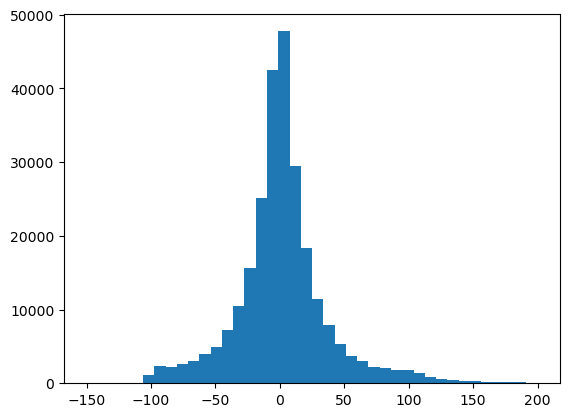

In [11]:
plt.hist(wego.HDWY_DEV_PERC, bins=40, range = (-150, 200))


Bunching occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. 
Gapping is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. 
Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 
The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, 
so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

bunching is <-50

normal is -50 to 50

gapping is >50

In [12]:
# Adding columns to indicate if headway was normal, bunching, or gapping

wego['HDWY_IS_BUNCHING'] = 0
wego['HDWY_IS_NORMAL'] = 0
wego['HDWY_IS_GAPPING'] = 0

def hdwy_cat(row):
    if row['HDWY_DEV_PERC'] < -50:
        row['HDWY_IS_BUNCHING'] = 1
    elif -50 <= row['HDWY_DEV_PERC'] <= 50:
        row['HDWY_IS_NORMAL'] = 1
    elif row['HDWY_DEV_PERC'] > 50:
        row['HDWY_IS_GAPPING'] = 1
    return row

wego = wego.apply(hdwy_cat, axis=1)

In [13]:
wego[['HDWY_IS_BUNCHING', 'HDWY_IS_NORMAL', 'HDWY_IS_GAPPING']].value_counts().sort_values().reset_index()

,HDWY_IS_BUNCHING,HDWY_IS_NORMAL,HDWY_IS_GAPPING,count
0,1,0,0,17243
1,0,0,1,20562
2,0,0,0,72640
3,0,1,0,223482


In [14]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PERC,HDWY_IS_BUNCHING,HDWY_IS_NORMAL,HDWY_IS_GAPPING
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN,NaN,0,0,0
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN,NaN,0,0,0
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN,NaN,0,0,0
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN,NaN,0,0,0
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0,NaN,0,0,0


In [15]:
# Pulling hour and day out of scheduled arrival time
wego['hour'] = pd.to_datetime(wego['SCHEDULED_TIME'], format='mixed').dt.hour
wego['day'] = pd.to_datetime(wego['SCHEDULED_TIME'], format='mixed').dt.day_name()

# Removing rows with no headway data for clean headway calculations - separate dataframe since it's many rows
wego_hdwy = wego[((wego['HDWY_IS_NORMAL'] != 0) | 
                  (wego['HDWY_IS_BUNCHING'] != 0) | 
                  (wego['HDWY_IS_GAPPING'] != 0))]

In [16]:
# Setting default to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Q1
### What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [17]:
# Percent of on-time, late, and early adherence stops
round(wego[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]\
      .mean()*100, 2).to_frame().reset_index().rename(columns={'index': 'Adherence Category', 0: 'Percentage'})

,Adherence Category,Percentage
0,ADJUSTED_ONTIME_COUNT,79.90
1,ADJUSTED_LATE_COUNT,17.27
2,ADJUSTED_EARLY_COUNT,2.83


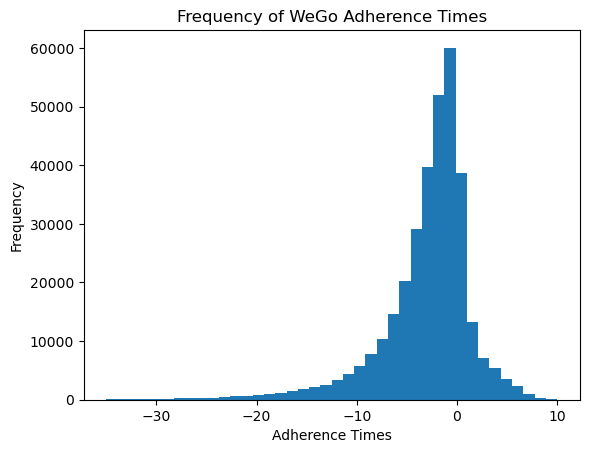

In [18]:
# Adherence distribution - removing non-visible outliers
plt.hist(wego.ADHERENCE, bins=40, range=(-35, 10))
plt.title('Frequency of WeGo Adherence Times')
plt.xlabel('Adherence Times')
plt.ylabel('Frequency')
plt.show() 

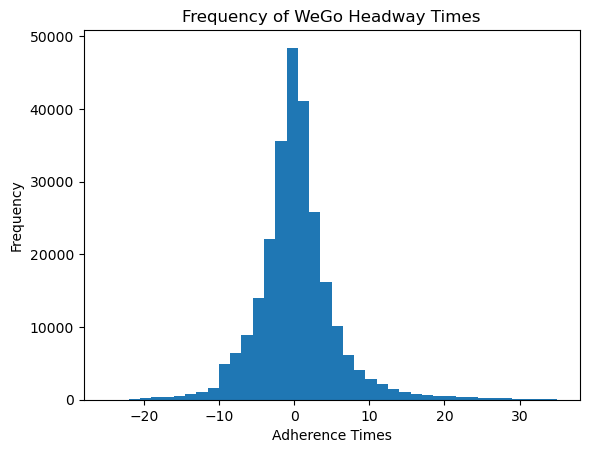

In [19]:
# Headway distribution - removing non-visible outliers
plt.hist(wego.HDWY_DEV, bins=40, range=(-25, 35))
plt.title('Frequency of WeGo Headway Times')
plt.xlabel('Adherence Times')
plt.ylabel('Frequency')
plt.show() 

# Q2
### How does direction of travel, route, or location affect the headway and on-time performance?

In [20]:
# Adjusted late perc will be very diff  
# on time perc: round((wego['ADJUSTED_ONTIME_COUNT'].sum()) / (wego.shape[0]) * 100, 2)
# Route is route_abbr (8 diff)
# Location is lat and long??? - Time point abbr is also location. maybe do groupby

### Direction of Travel

In [21]:
# Headway
direction_hdwy = wego_hdwy.groupby('ROUTE_DIRECTION_NAME')[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']].mean().reset_index()
direction_hdwy[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] *= 100
direction_hdwy

,ROUTE_DIRECTION_NAME,HDWY_IS_NORMAL,HDWY_IS_BUNCHING,HDWY_IS_GAPPING
0,FROM DOWNTOWN,82.61,8.07,9.32
1,TO DOWNTOWN,88.86,4.92,6.22


In [22]:
# Adherence
direction_adherence = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]\
      .mean().reset_index()

direction_adherence[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']] *= 100

direction_adherence.rename(columns={'ADJUSTED_ONTIME_COUNT': 'ADJUSTED_ONTIME_PERC', 'ADJUSTED_LATE_COUNT': 'ADJUSTED_LATE_PERC', 'ADJUSTED_EARLY_COUNT': 'ADJUSTED_EARLY_PERC'}, inplace=True)

direction_adherence

,ROUTE_DIRECTION_NAME,ADJUSTED_ONTIME_PERC,ADJUSTED_LATE_PERC,ADJUSTED_EARLY_PERC
0,FROM DOWNTOWN,75.22,21.89,2.89
1,TO DOWNTOWN,85.17,12.07,2.76


### Route

In [23]:
route_names = {
    3: 'West End',
    7: 'Hillsboro',
    22: 'Bordeaux',
    23: 'Dickerson Pike',
    50: 'Charlotte Pike',
    52: 'Nolensville Pike',
    55: 'Murfreesboro Pike',
    56: 'Gallatin Pike'
}

In [24]:
# Headway
route_hdwy = wego_hdwy.groupby('ROUTE_ABBR')[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']].mean().reset_index() \
    .assign(ROUTE_ABBR=lambda x: x['ROUTE_ABBR'].map(route_names))\
    .rename(columns={'ROUTE_ABBR': 'ROUTE'})
route_hdwy[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] *= 100
route_hdwy

,ROUTE,HDWY_IS_NORMAL,HDWY_IS_BUNCHING,HDWY_IS_GAPPING
0,West End,86.51,5.81,7.68
1,Hillsboro,91.23,3.74,5.03
2,Bordeaux,94.07,1.78,4.16
3,Dickerson Pike,91.48,2.17,6.35
4,Charlotte Pike,93.40,2.95,3.66
5,Nolensville Pike,83.86,7.20,8.94
6,Murfreesboro Pike,74.15,13.14,12.70
7,Gallatin Pike,84.50,7.49,8.01


In [25]:
# Adherence
route_adherence = wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]\
      .mean().reset_index().assign(ROUTE_ABBR=lambda x: x['ROUTE_ABBR'].map(route_names))

route_adherence[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']] *= 100

route_adherence.rename(columns={'ROUTE_ABBR': 'ROUTE', 'ADJUSTED_ONTIME_COUNT': 'ADJUSTED_ONTIME_PERC', 'ADJUSTED_LATE_COUNT': 'ADJUSTED_LATE_PERC', 'ADJUSTED_EARLY_COUNT': 'ADJUSTED_EARLY_PERC'}, inplace=True)

route_adherence.sort_values('ADJUSTED_ONTIME_PERC', ascending=False)

,ROUTE,ADJUSTED_ONTIME_PERC,ADJUSTED_LATE_PERC,ADJUSTED_EARLY_PERC
2,Bordeaux,89.29,8.17,2.54
3,Dickerson Pike,88.79,8.05,3.16
4,Charlotte Pike,85.33,11.88,2.79
7,Gallatin Pike,82.24,14.84,2.92
1,Hillsboro,77.99,19.80,2.21
5,Nolensville Pike,76.96,19.97,3.07
0,West End,76.04,20.97,2.99
6,Murfreesboro Pike,70.02,27.46,2.52


### Location

In [26]:
# Headway
location_hdwy = wego.groupby('TIME_POINT_ABBR')[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']].mean().reset_index()
location_hdwy[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] *= 100
location_hdwy

,TIME_POINT_ABBR,HDWY_IS_NORMAL,HDWY_IS_BUNCHING,HDWY_IS_GAPPING
0,21BK,87.35,4.61,5.98
1,25ACLARK,46.07,0.04,1.05
2,28&CHARL,91.52,3.08,3.68
3,ARTS,0.00,0.00,0.00
4,BRCJ,89.44,2.04,5.49
...,...,...,...,...
56,WE23,81.91,7.53,9.10
57,WE31,81.75,7.50,9.30
58,WHBG,73.91,2.34,3.09
59,WMRT,81.54,8.23,8.81


In [27]:
# Adherence
location_adherence = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]\
      .mean().reset_index()

location_adherence[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']] *= 100

location_adherence.rename(columns={'TIME_POINT_ABBR': 'LOCATION', 'ADJUSTED_ONTIME_COUNT': 'ADJUSTED_ONTIME_PERC', 'ADJUSTED_LATE_COUNT': 'ADJUSTED_LATE_PERC', 'ADJUSTED_EARLY_COUNT': 'ADJUSTED_EARLY_PERC'}, inplace=True)

location_adherence.sort_values('ADJUSTED_ONTIME_PERC', ascending=False)

,LOCATION,ADJUSTED_ONTIME_PERC,ADJUSTED_LATE_PERC,ADJUSTED_EARLY_PERC
40,MCC5_6,99.14,0.86,0.00
1,25ACLARK,97.90,1.60,0.50
35,MCC5_10,95.62,4.14,0.25
33,MCC4_24,95.28,4.31,0.40
44,MHSP,91.15,7.95,0.90
...,...,...,...,...
21,HEAD,51.39,4.17,44.44
37,MCC5_12,41.03,58.97,0.00
36,MCC5_11,31.15,68.85,0.00
27,MCC4_13,28.79,4.55,66.67


# Q3
### How does time of day or day of week affect headway and on-time performance?

### Headway

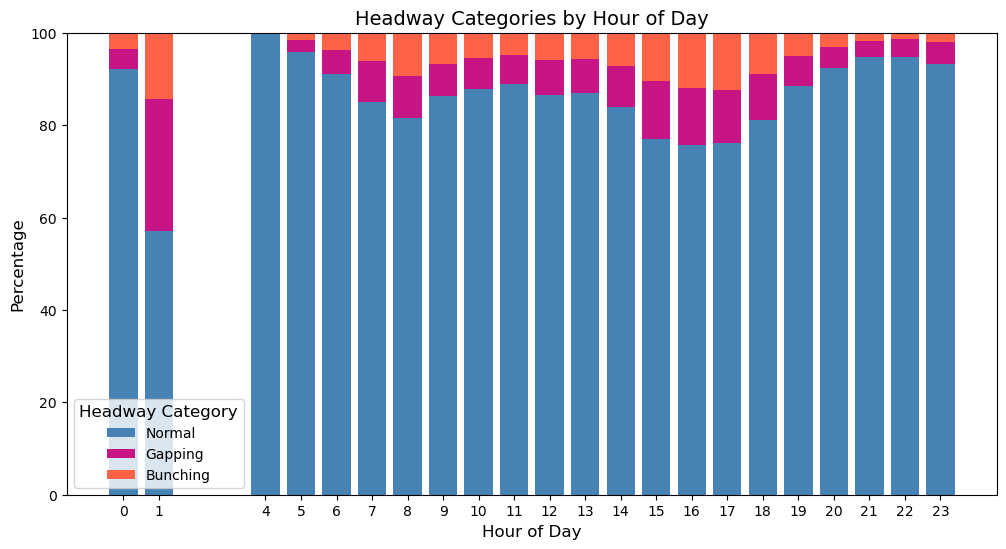

In [84]:
# Stacked bar chart version for hour
h = wego_hdwy.groupby('hour')[['HDWY_IS_NORMAL', 'HDWY_IS_GAPPING', 'HDWY_IS_BUNCHING']].mean().reset_index()

hours = h['hour']
normal = h['HDWY_IS_NORMAL']*100
bunching = h['HDWY_IS_BUNCHING']*100
gapping = h['HDWY_IS_GAPPING']*100

plt.figure(figsize=(12, 6))
plt.bar(hours, normal, label='Normal', color='SteelBlue')
plt.bar(hours, gapping, bottom=normal, label='Gapping', color='MediumVioletRed')
plt.bar(hours, bunching, bottom=normal+gapping, label='Bunching', color='Tomato')

# Fine tuning
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Headway Categories by Hour of Day', fontsize=14)
plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.xticks(hours)  # Shows all the hour labels - might remove this
plt.show()

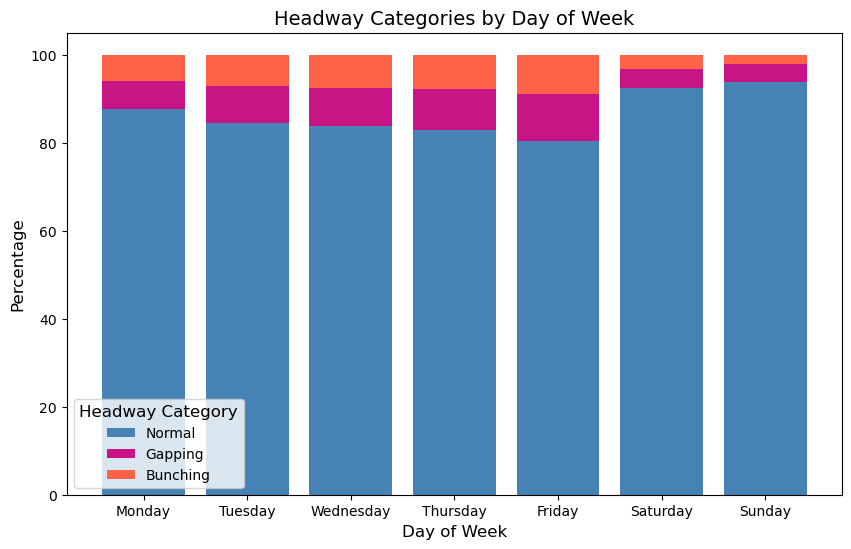

In [85]:
# Stacked bar chart version for day of week

# Defining the order of days of the week
days_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

d = wego_hdwy.groupby('day')[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']].mean().reset_index()
d = d.set_index('day').loc[days_of_week_order].reset_index()

hours = d['day']
normal = d['HDWY_IS_NORMAL']*100
bunching = d['HDWY_IS_BUNCHING']*100
gapping = d['HDWY_IS_GAPPING']*100

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(hours, normal, label='Normal', color='SteelBlue')
plt.bar(hours, gapping, bottom=normal, label='Gapping', color='MediumVioletRed')
plt.bar(hours, bunching, bottom=normal+gapping, label='Bunching', color='Tomato')

# Fine tuning
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Headway Categories by Day of Week', fontsize=14)
ax.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.show()

### On-Time Performance

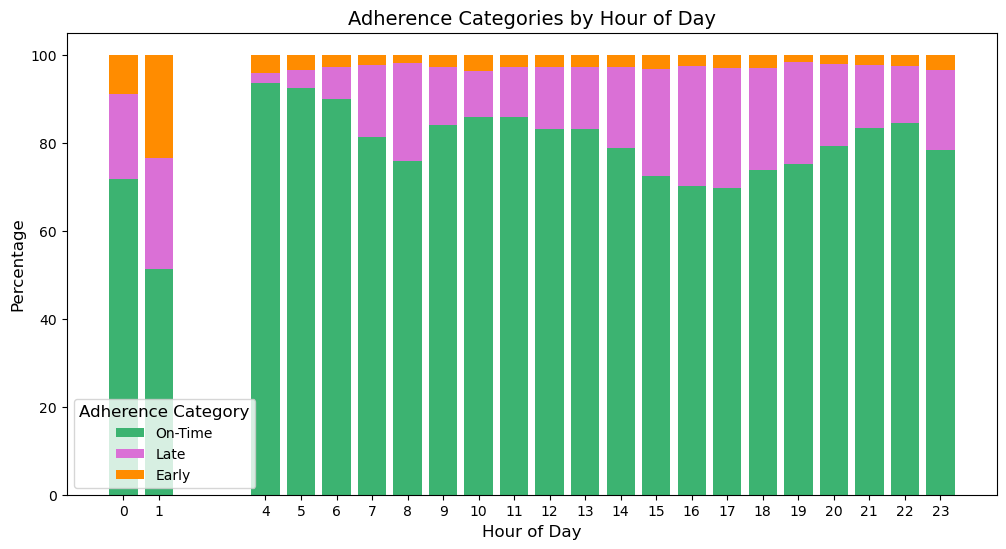

In [86]:
# Adherence by hour of day

# Creating dataframe to look at adherence by hour
h2 = ((wego.groupby('hour')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
       .mean().reset_index()))

hours = h2['hour']
ontime = h2['ADJUSTED_ONTIME_COUNT']*100
late = h2['ADJUSTED_LATE_COUNT']*100
early = h2['ADJUSTED_EARLY_COUNT']*100

plt.figure(figsize=(12, 6))
plt.bar(hours, ontime, label='On-Time', color='MediumSeaGreen')
plt.bar(hours, late, bottom=ontime, label='Late', color='Orchid')
plt.bar(hours, early, bottom=ontime+late, label='Early', color='DarkOrange')

# Fine tuning
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Adherence Categories by Hour of Day', fontsize=14)
plt.legend(title='Adherence Category', fontsize=10, title_fontsize=12)
plt.xticks(hours)  # Shows all the hour labels - might remove this
plt.show()

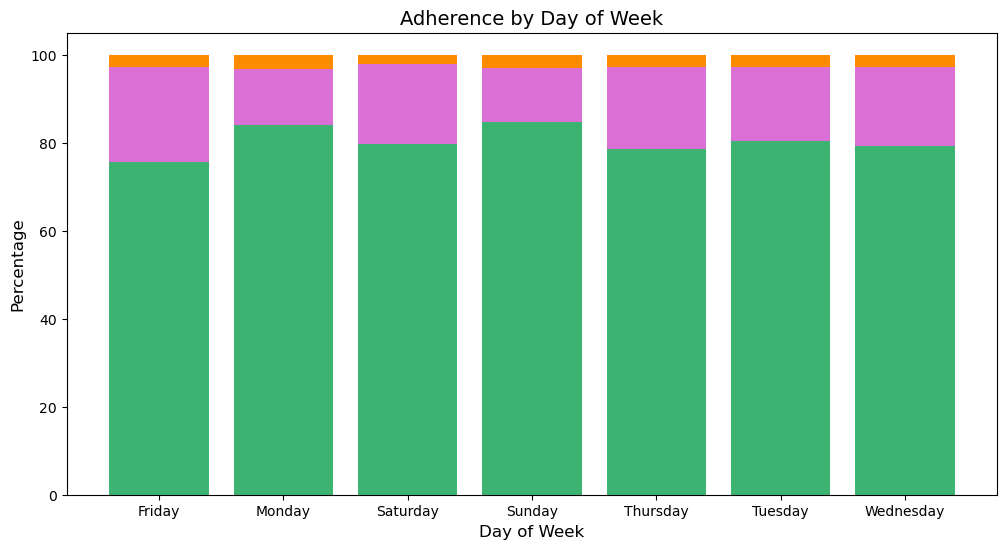

In [88]:
# Creating dataframe to look at OTP by day
d2 = ((wego.groupby('day')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
       .mean().reset_index()))

days = d2['day']
ontime = d2['ADJUSTED_ONTIME_COUNT']*100
late = d2['ADJUSTED_LATE_COUNT']*100
early = d2['ADJUSTED_EARLY_COUNT']*100

plt.figure(figsize=(12, 6))
plt.bar(days, ontime, label='On-Time', color='MediumSeaGreen')
plt.bar(days, late, bottom=ontime, label='Late', color='Orchid')
plt.bar(days, early, bottom=ontime+late, label='Early', color='DarkOrange')

# Fine tuning
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.title("Adherence by Day of Week", fontsize=14)

plt.show()

In [32]:
# 4: how many operators are there, and how many routes did they each drive? 
# Come up with cutoff (ex 500 trips or less, drop them; 

# boxplot for days of week???

# Q4
### How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

### Adherence

In [33]:
# There are 340 different drivers in the dataset
wego['OPERATOR'].nunique()

340

In [57]:
# Getting unique trip and operator by dropping duplicates (we want # trips, not # stops)
operator_trip_counts = wego[['TRIP_ID', 'CALENDAR_ID', 'OPERATOR']].drop_duplicates()

# Grouping by operator to view # trips
operator_trip_counts = operator_trip_counts.groupby('OPERATOR').size().reset_index(name='Number_of_Trips')\
    .sort_values('Number_of_Trips', ascending=False).reset_index(drop=True)

operator_trip_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   OPERATOR         340 non-null    object
 1   Number_of_Trips  340 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [61]:
# Creating a cutoff to eliminate short-term drivers (bottom ~10%)
operator_trip_counts_cutoff = operator_trip_counts[operator_trip_counts['Number_of_Trips']>=80]

operator_trip_counts_cutoff.head()

,OPERATOR,Number_of_Trips
0,1762,786
1,1761,719
2,2164,570
3,379,550
4,1170,532


In [36]:
# Getting top and bottom 50% drivers based on # trips driven
median_trips = operator_trip_counts_cutoff['Number_of_Trips'].median()

operator_trip_counts_top = operator_trip_counts_cutoff[operator_trip_counts_cutoff['Number_of_Trips'] >= median_trips]
operator_trip_counts_bottom = operator_trip_counts_cutoff[operator_trip_counts_cutoff['Number_of_Trips'] < median_trips]

In [68]:
op_adh_merged

,OPERATOR,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
0,1040,0.96,0.01,0.03
1,1052,0.90,0.10,0.00
2,1133,0.95,0.04,0.00
3,1147,0.91,0.03,0.06
4,1170,0.91,0.01,0.09
...,...,...,...,...
248,659,0.78,0.02,0.19
249,723,0.96,0.02,0.02
250,778,0.83,0.11,0.06
251,785,0.88,0.05,0.07


In [92]:
# Correlation between an operator's route and their on-time performance

operator_route_adherence = wego_filtered.groupby(['OPERATOR', 'ROUTE_ABBR'])[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].mean().reset_index()

operator_route_adherence['ROUTE_ABBR'].corr(operator_route_adherence['ADJUSTED_ONTIME_COUNT'])


-0.037668121286999035

In [95]:
operator_route_adherence.head()

,OPERATOR,ROUTE_ABBR,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
0,1175,3,0.80,0.19,0.01
1,1175,7,1.00,0.00,0.00
2,1175,22,0.86,0.10,0.03
3,1175,50,0.92,0.06,0.01
4,1175,52,0.85,0.15,0.00


In [93]:
# Correlation between an operator's route and their normal headway

operator_route_headway = wego_filtered.groupby(['OPERATOR', 'ROUTE_ABBR'])[['HDWY_IS_NORMAL', 'HDWY_IS_GAPPING', 'HDWY_IS_BUNCHING']].mean().reset_index()

operator_route_headway['ROUTE_ABBR'].corr(operator_route_headway['HDWY_IS_NORMAL'])

0.07285910399604209

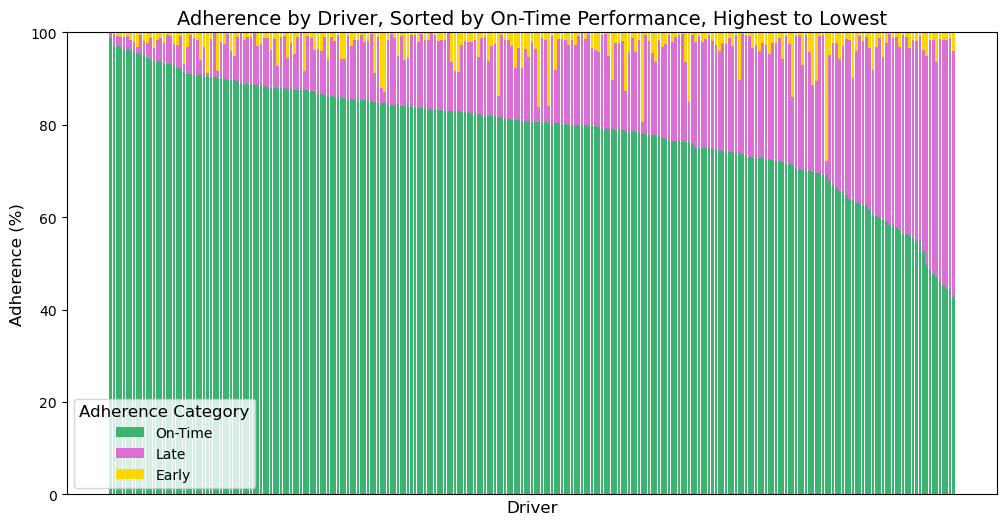

In [70]:
# Looking at only drivers with 80+ trips
wego_filtered = wego[wego['OPERATOR'].isin(operator_trip_counts_cutoff['OPERATOR'])]

operator_adherence = wego_filtered.groupby('OPERATOR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].mean().reset_index()

operator_adherence = operator_adherence.sort_values(by='ADJUSTED_ONTIME_COUNT', ascending=False)

operator_adherence['OPERATOR'] = operator_adherence['OPERATOR'].astype(str)
operator_adherence['OPERATOR'] = pd.Categorical(operator_adherence['OPERATOR'], categories=operator_adherence['OPERATOR'], ordered=True)

operator = operator_adherence['OPERATOR']
ontime = operator_adherence['ADJUSTED_ONTIME_COUNT'] * 100
late = operator_adherence['ADJUSTED_LATE_COUNT'] * 100  
early = operator_adherence['ADJUSTED_EARLY_COUNT'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, ontime, label='On-Time', color='MediumSeaGreen')
plt.bar(operator, late, bottom=ontime, label='Late', color='Orchid')
plt.bar(operator, early, bottom=ontime+late, label='Early', color='Gold')

# Fine tuning
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Adherence (%)", fontsize=12)
plt.title("Adherence by Driver, Sorted by On-Time Performance, Highest to Lowest", fontsize=14)
plt.legend(title='Adherence Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()

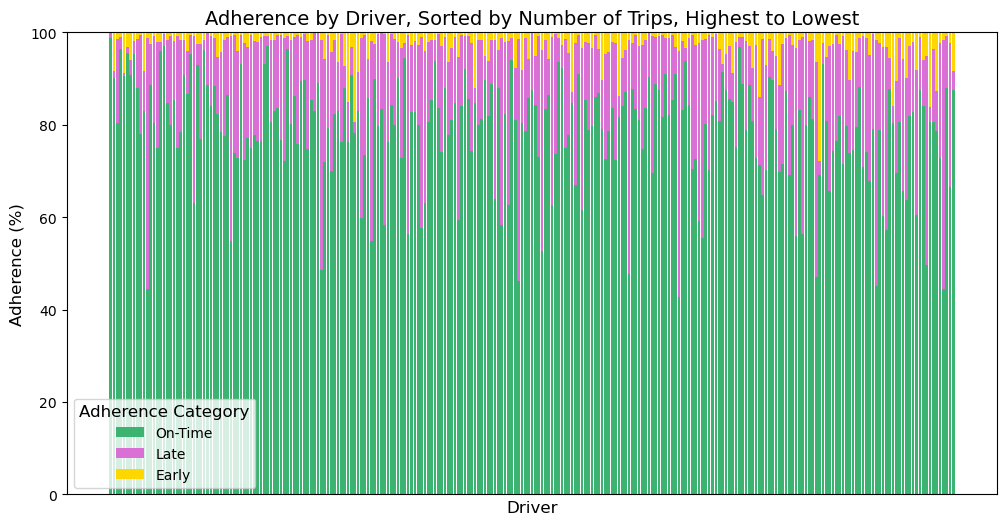

In [75]:
# Same, but sorted by # trips

op_adh_merged = pd.merge(operator_adherence, operator_trip_counts_cutoff, on='OPERATOR')
op_adh_merged = op_adh_merged.sort_values(by='Number_of_Trips', ascending=False)

operator = op_adh_merged['OPERATOR']
ontime = op_adh_merged['ADJUSTED_ONTIME_COUNT'] * 100
late = op_adh_merged['ADJUSTED_LATE_COUNT'] * 100  
early = op_adh_merged['ADJUSTED_EARLY_COUNT'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, ontime, label='On-Time', color='MediumSeaGreen')
plt.bar(operator, late, bottom=ontime, label='Late', color='Orchid')
plt.bar(operator, early, bottom=ontime+late, label='Early', color='Gold')

# Fine tuning
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Adherence (%)", fontsize=12)
plt.title("Adherence by Driver, Sorted by Number of Trips, Highest to Lowest", fontsize=14)
plt.legend(title='Adherence Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()

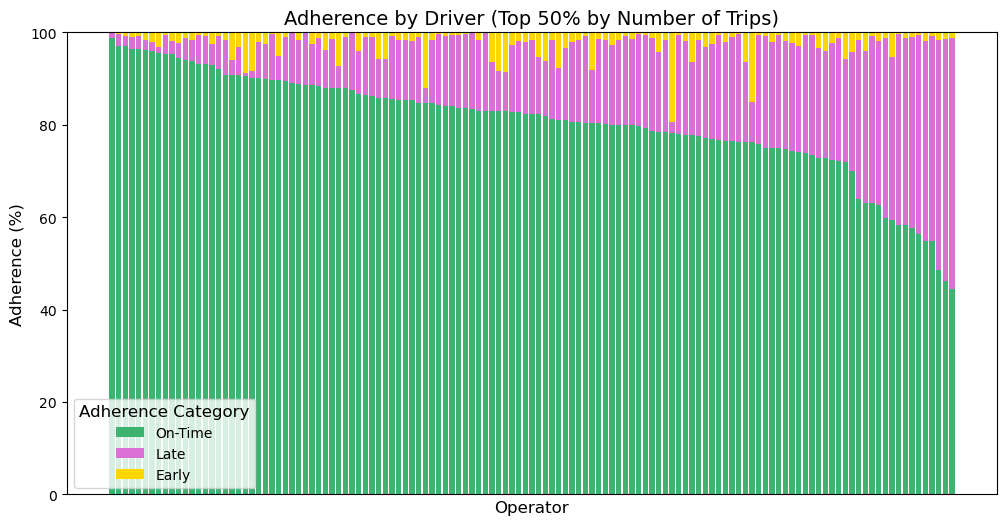

In [72]:
# Top 50% drivers
wego_filtered = wego[wego['OPERATOR'].isin(operator_trip_counts_top['OPERATOR'])]

top_operator_adherence = wego_filtered.groupby('OPERATOR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].mean().reset_index()

top_operator_adherence = top_operator_adherence.sort_values(by='ADJUSTED_ONTIME_COUNT', ascending=False)

top_operator_adherence['OPERATOR'] = top_operator_adherence['OPERATOR'].astype(str)
top_operator_adherence['OPERATOR'] = pd.Categorical(top_operator_adherence['OPERATOR'], categories=top_operator_adherence['OPERATOR'], ordered=True)

operator = top_operator_adherence['OPERATOR']
ontime = top_operator_adherence['ADJUSTED_ONTIME_COUNT'] * 100
late = top_operator_adherence['ADJUSTED_LATE_COUNT'] * 100  
early = top_operator_adherence['ADJUSTED_EARLY_COUNT'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, ontime, label='On-Time', color='MediumSeaGreen')
plt.bar(operator, late, bottom=ontime, label='Late', color='Orchid')
plt.bar(operator, early, bottom=ontime+late, label='Early', color='Gold')

# Fine tuning
plt.xlabel("Operator", fontsize=12)
plt.ylabel("Adherence (%)", fontsize=12)
plt.title("Adherence by Driver (Top 50% by Number of Trips)", fontsize=14)
plt.legend(title='Adherence Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()

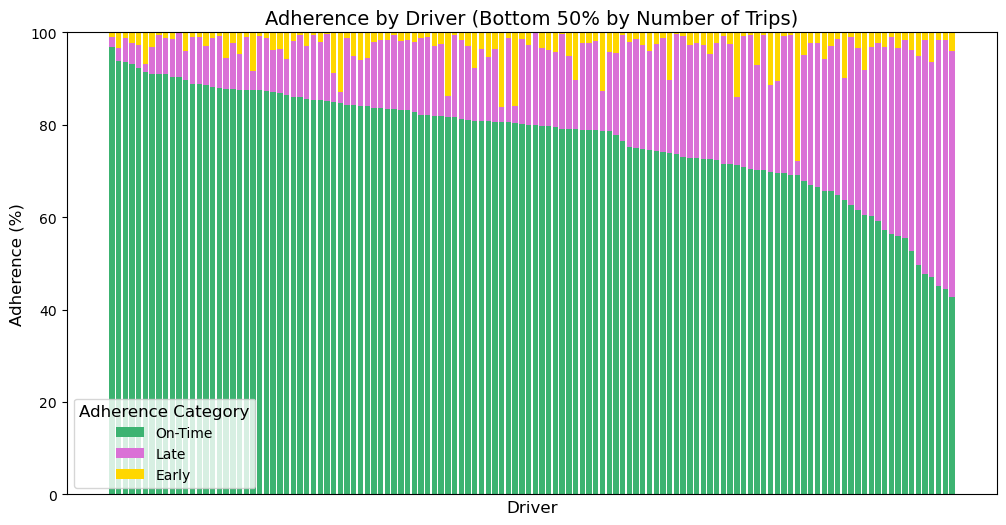

In [73]:
# Bottom 50% drivers
wego_filtered = wego[wego['OPERATOR'].isin(operator_trip_counts_bottom['OPERATOR'])]

bottom_operator_adherence = wego_filtered.groupby('OPERATOR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].mean().reset_index()

bottom_operator_adherence = bottom_operator_adherence.sort_values(by='ADJUSTED_ONTIME_COUNT', ascending=False)

bottom_operator_adherence['OPERATOR'] = bottom_operator_adherence['OPERATOR'].astype(str)
bottom_operator_adherence['OPERATOR'] = pd.Categorical(bottom_operator_adherence['OPERATOR'], categories=operator_adherence['OPERATOR'], ordered=True)

operator = bottom_operator_adherence['OPERATOR']
ontime = bottom_operator_adherence['ADJUSTED_ONTIME_COUNT'] * 100
late = bottom_operator_adherence['ADJUSTED_LATE_COUNT'] * 100  
early = bottom_operator_adherence['ADJUSTED_EARLY_COUNT'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, ontime, label='On-Time', color='MediumSeaGreen')
plt.bar(operator, late, bottom=ontime, label='Late', color='Orchid')
plt.bar(operator, early, bottom=ontime+late, label='Early', color='Gold')

# Fine tuning
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Adherence (%)", fontsize=12)
plt.title("Adherence by Driver (Bottom 50% by Number of Trips)", fontsize=14)
plt.legend(title='Adherence Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()

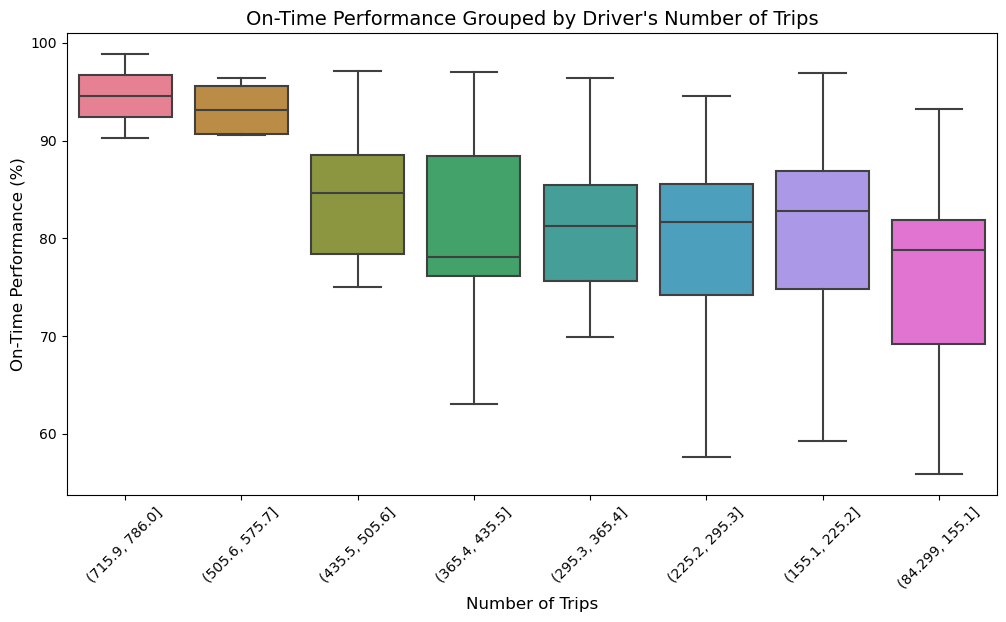

In [76]:
# Boxplot showing bins based on operator's # trips

# Convert 'OPERATOR' column in both DataFrames to the same data type
operator_trip_counts_cutoff.loc[:, 'OPERATOR'] = operator_trip_counts_cutoff['OPERATOR'].astype(str)
operator_adherence['OPERATOR'] = operator_adherence['OPERATOR'].astype(str)

# Merge operator_trip_counts and operator_adherence on 'OPERATOR'
merged_data = pd.merge(operator_trip_counts_cutoff, operator_adherence, on='OPERATOR')

# Creating 10 bins
merged_data['Trip_Bins'] = pd.cut(merged_data['Number_of_Trips'], bins=10)
merged_data['Trip_Bins_Label'] = merged_data['Trip_Bins'].astype(str)
merged_data[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']] *= 100

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Trip_Bins_Label', y='ADJUSTED_ONTIME_COUNT', data=merged_data, showfliers=False, palette='husl')

# Fine tuning
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('On-Time Performance (%)', fontsize=12)
plt.title("On-Time Performance Grouped by Driver's Number of Trips", fontsize=14)
plt.xticks(rotation=45)

plt.show()

In [41]:
# Correlation (moderate positive correlation)
merged_data['Number_of_Trips'].corr(merged_data['ADJUSTED_ONTIME_COUNT'])

0.25421034950005533

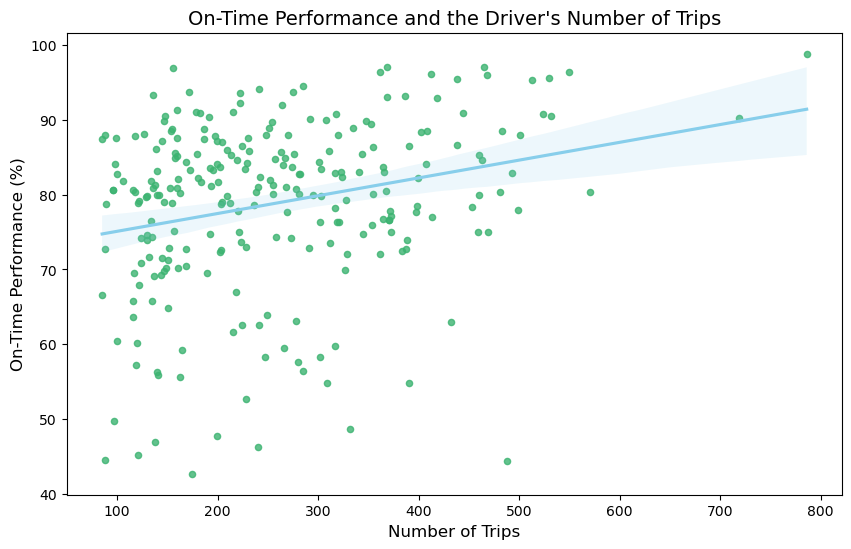

In [80]:
# Scatterplot of # trips and OTP

# Plotting
plt.figure(figsize=(10, 6))
sns.regplot(x='Number_of_Trips', y='ADJUSTED_ONTIME_COUNT', data=merged_data, scatter_kws={'s': 20}, color='MediumSeaGreen', line_kws={'color': 'SkyBlue'})

# Fine tuning
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('On-Time Performance (%)', fontsize=12)
plt.title("On-Time Performance and the Driver's Number of Trips", fontsize=14)

# Show the plot
plt.show()

### Headway

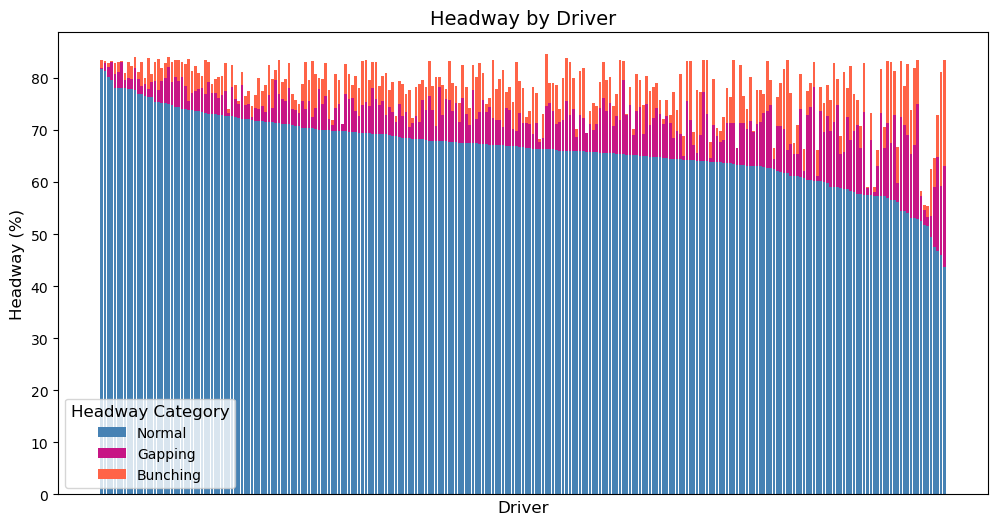

In [94]:
# Looking at only drivers with 80+ trips
wego['OPERATOR'] = wego['OPERATOR'].astype(str)
wego_filtered = wego[wego['OPERATOR'].isin(operator_trip_counts_cutoff['OPERATOR'])]

operator_headway = wego_filtered.groupby('OPERATOR')[['HDWY_IS_NORMAL', 'HDWY_IS_GAPPING', 'HDWY_IS_BUNCHING']].mean().reset_index()

operator_headway = operator_headway.sort_values('HDWY_IS_NORMAL', ascending=False)

# operator_headway['OPERATOR'] = operator_adherence['OPERATOR'].astype(str)
operator_headway['OPERATOR'] = pd.Categorical(operator_adherence['OPERATOR'], categories=operator_adherence['OPERATOR'], ordered=True)

operator = operator_headway['OPERATOR']
normal = operator_headway['HDWY_IS_NORMAL'] * 100
gapping = operator_headway['HDWY_IS_GAPPING'] * 100  
bunching = operator_headway['HDWY_IS_BUNCHING'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, normal, label='Normal', color='SteelBlue')
plt.bar(operator, gapping, bottom=normal, label='Gapping', color='MediumVioletRed')
plt.bar(operator, bunching, bottom=normal+gapping, label='Bunching', color='Tomato')

# Fine tuning
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Headway (%)", fontsize=12)
plt.title("Headway by Driver", fontsize=14)
plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()

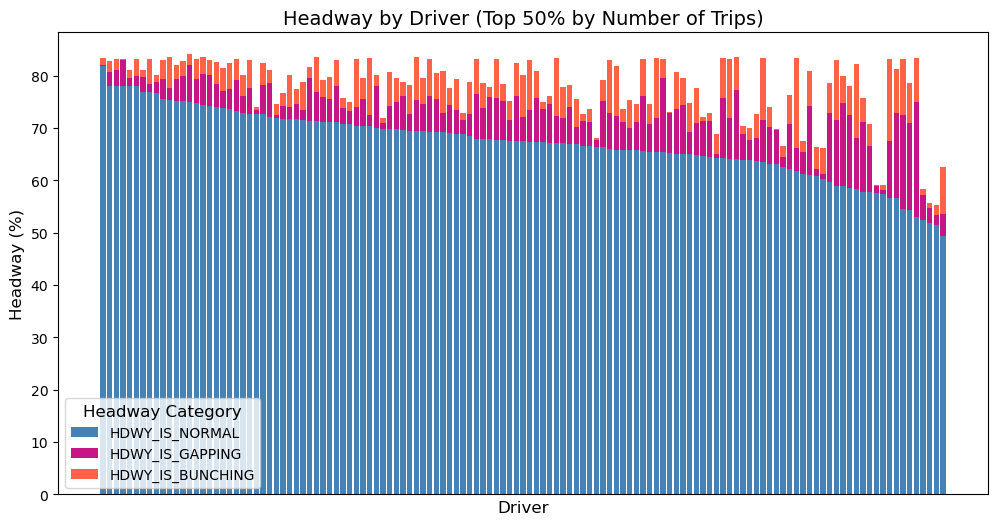

In [44]:
# Top 50%

# Looking at only drivers with 80+ trips
wego['OPERATOR'] = wego['OPERATOR'].astype(str)
operator_trip_counts_top = operator_trip_counts_top.copy()
operator_trip_counts_top['OPERATOR'] = operator_trip_counts_top['OPERATOR'].astype(str)
wego_filtered = wego[wego['OPERATOR'].isin(operator_trip_counts_top['OPERATOR'])]

top_operator_headway = wego_filtered.groupby('OPERATOR')[['HDWY_IS_NORMAL', 'HDWY_IS_GAPPING', 'HDWY_IS_BUNCHING']].mean().reset_index()

top_operator_headway = top_operator_headway.sort_values('HDWY_IS_NORMAL', ascending=False)

top_operator_headway['OPERATOR'] = top_operator_headway['OPERATOR'].astype(str)
top_operator_headway['OPERATOR'] = pd.Categorical(top_operator_headway['OPERATOR'], categories=top_operator_headway['OPERATOR'], ordered=True)

operator = top_operator_headway['OPERATOR']
normal = top_operator_headway['HDWY_IS_NORMAL'] * 100
gapping = top_operator_headway['HDWY_IS_GAPPING'] * 100  
bunching = top_operator_headway['HDWY_IS_BUNCHING'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, normal, label='HDWY_IS_NORMAL', color='SteelBlue')
plt.bar(operator, gapping, bottom=normal, label='HDWY_IS_GAPPING', color='MediumVioletRed')
plt.bar(operator, bunching, bottom=normal+gapping, label='HDWY_IS_BUNCHING', color='Tomato')

# Fine tuning
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Headway (%)", fontsize=12)
plt.title("Headway by Driver (Top 50% by Number of Trips)", fontsize=14)
plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()


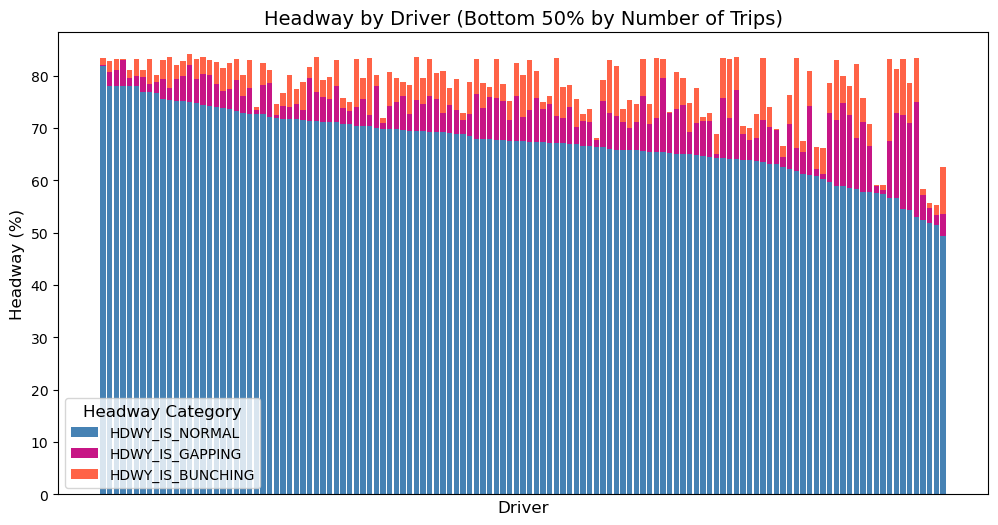

In [45]:
# Bottom 50%

# Looking at only drivers with 80+ trips
wego['OPERATOR'] = wego['OPERATOR'].astype(str)
operator_trip_counts_bottom = operator_trip_counts_bottom.copy()
operator_trip_counts_bottom['OPERATOR'] = operator_trip_counts_bottom['OPERATOR'].astype(str)
wego_filtered = wego[wego['OPERATOR'].isin(operator_trip_counts_bottom['OPERATOR'])]

bottom_operator_headway = wego_filtered.groupby('OPERATOR')[['HDWY_IS_NORMAL', 'HDWY_IS_GAPPING', 'HDWY_IS_BUNCHING']].mean().reset_index()

bottom_operator_headway = top_operator_headway.sort_values('HDWY_IS_NORMAL', ascending=False)

bottom_operator_headway['OPERATOR'] = bottom_operator_headway['OPERATOR'].astype(str)
bottom_operator_headway['OPERATOR'] = pd.Categorical(bottom_operator_headway['OPERATOR'], categories=bottom_operator_headway['OPERATOR'], ordered=True)

operator = bottom_operator_headway['OPERATOR']
normal = bottom_operator_headway['HDWY_IS_NORMAL'] * 100
gapping = bottom_operator_headway['HDWY_IS_GAPPING'] * 100  
bunching = bottom_operator_headway['HDWY_IS_BUNCHING'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(operator, normal, label='HDWY_IS_NORMAL', color='SteelBlue')
plt.bar(operator, gapping, bottom=normal, label='HDWY_IS_GAPPING', color='MediumVioletRed')
plt.bar(operator, bunching, bottom=normal+gapping, label='HDWY_IS_BUNCHING', color='Tomato')

# Fine tuning
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Headway (%)", fontsize=12)
plt.title("Headway by Driver (Bottom 50% by Number of Trips)", fontsize=14)
plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.xticks([])

plt.show()

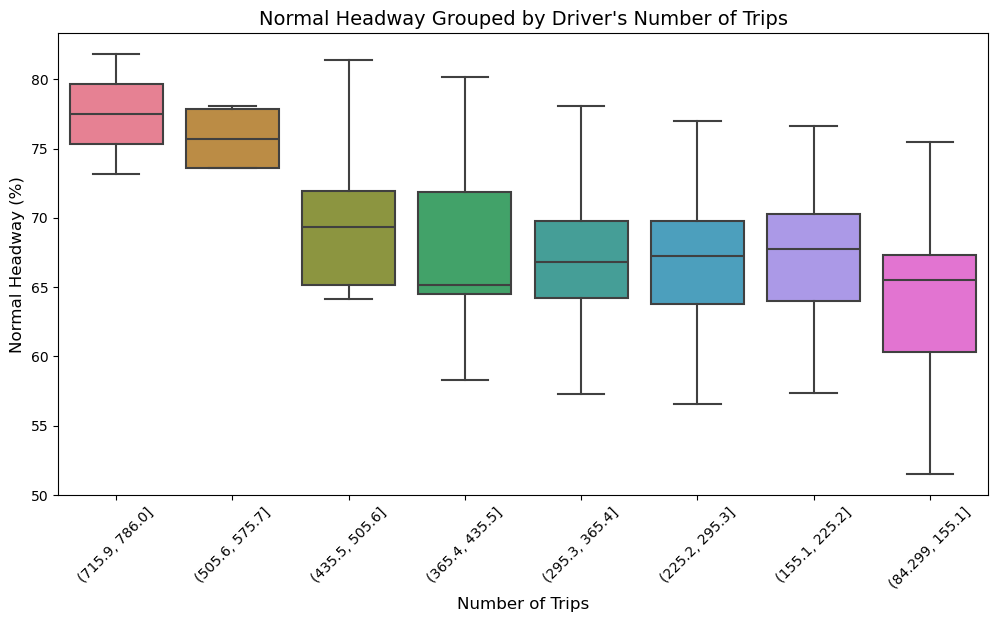

In [81]:
# Boxplot showing bins based on operator's # trips

# # Convert 'OPERATOR' column in both DataFrames to the same data type
# operator_trip_counts_cutoff.loc[:, 'OPERATOR'] = operator_trip_counts_cutoff['OPERATOR'].astype(str)
# operator_adherence['OPERATOR'] = operator_adherence['OPERATOR'].astype(str)

# Merge operator_trip_counts and operator_adherence on 'OPERATOR'
merged_data = pd.merge(operator_trip_counts_cutoff, operator_headway, on='OPERATOR')

# Creating 10 bins
merged_data['Trip_Bins'] = pd.cut(merged_data['Number_of_Trips'], bins=10)
merged_data['Trip_Bins_Label'] = merged_data['Trip_Bins'].astype(str)
merged_data[['HDWY_IS_NORMAL', 'HDWY_IS_GAPPING', 'HDWY_IS_BUNCHING']] *= 100

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Trip_Bins_Label', y='HDWY_IS_NORMAL', data=merged_data, palette='husl', showfliers=False)

# Fine tuning
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Normal Headway (%)', fontsize=12)
plt.title("Normal Headway Grouped by Driver's Number of Trips", fontsize=14)
plt.xticks(rotation=45)

plt.show()

In [47]:
# Correlation (moderate positive correlation)
merged_data['Number_of_Trips'].corr(merged_data['HDWY_IS_NORMAL'])

0.2828207269847551

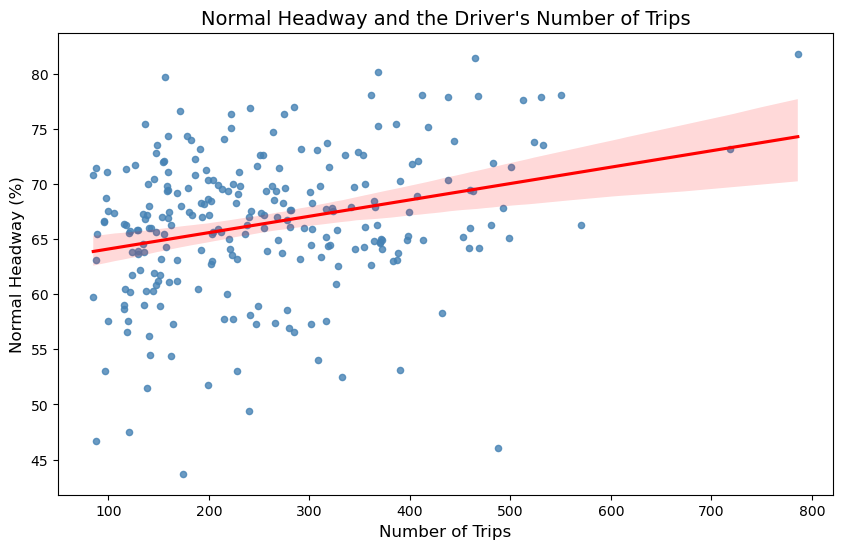

In [83]:
# Scatterplot of # trips and Headway

# Plotting
plt.figure(figsize=(10, 6))
sns.regplot(x='Number_of_Trips', y='HDWY_IS_NORMAL', data=merged_data, color='SteelBlue', scatter_kws={'s': 20}, line_kws={'color': 'red'})

# Fine tuning
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Normal Headway (%)', fontsize=12)
plt.title("Normal Headway and the Driver's Number of Trips", fontsize=14)

# Show the plot
plt.show()

In [49]:
# establish color consistency! 
